<h1 align="center"> Image Captioning</h1>

Будем обучать нейросеть создавать описание к изображению (image captioning)
![img](https://i.imgur.com/obITaMl.png)



#### План:
1. Используем предобученный inception v3 для получения эмбеддингов изображений
2. Накладываем поверх LSTM
3. Обучаем на [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Грузим данные из from https://yadi.sk/d/b4nAwIE73TVcp5 или генерируем вручную с помощью preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Считываем датасет
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 1.13 s, sys: 7.49 s, total: 8.62 s
Wall time: 5.96 s


### Data structure

Изображения из MSCOCO17 уже заранее векторизованы с помощью предобученной inception_v3 из
[torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

In [3]:
print("Каждый эмбеддинг изображения это 2048-мерный вектор [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("Для каждого изображения 5 разных описаний, например:\n")
print('\n'.join(captions[0]))

Каждый эмбеддинг изображения это 2048-мерный вектор [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

Для каждого изображения 5 разных описаний, например:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видите, все описания уже токенизированы и приведены к нижнему регистру. Теперь мы хотим разделить их и добавить несколько специальных токенов для начала / конца описания.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

Мы не хотим, чтобы наша сеть предсказывала вектор вероятностей размера в миллион на каждом шаге, поэтому мы сделаем некоторые сокращения.

Мы хотим __посчитать частоту поялвения каждого слова__, чтобы можно было решить какие слова оставить в словаре.

In [5]:
# Build a Vocabulary
from collections import Counter
from tqdm import tqdm_notebook as tqdm

word_counts = Counter()
for img_i in tqdm(range(len(captions))):
    for caption_i in range(len(captions[img_i])):
        word_counts.update(captions[img_i][caption_i])

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    matrix = np.full((len(sequences), max_len), pad_ix, dtype='int32')
    for i, seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Создадим нейросеть

Построим rnn модель языка, входными состояниями которой будут эмбеддинги полученые из cnn

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=1)
        self.lstm = nn.LSTM(emb_size, lstm_units, num_layers=1, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        captions_emb = self.emb(captions_ix)
        
        # lstm_out shape: [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
network = CaptionNet(n_tokens)

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    loss = torch.nn.CrossEntropyLoss(ignore_index=pad_ix)(logits_for_next.permute(0,2,1), captions_ix_next).view(1)
    
    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

# Training

* Во-первых добавим генератор батчей
* Затем обычная тренировачная рутина

In [15]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [16]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [17]:
generate_batch(img_codes,captions,3)

(tensor([[0.0840, 0.1592, 0.1308,  ..., 0.0990, 0.0609, 0.2082],
         [0.7679, 0.1443, 0.5148,  ..., 0.0673, 0.0837, 0.2476],
         [0.1923, 0.1003, 0.9025,  ..., 0.0220, 0.1535, 0.2694]]),
 tensor([[   1,   24,   29,   41,  384,   24,   83,   35,   24,   79,   12,    2],
         [   1,   24,  718,  476, 1000, 3934, 4922,   15,  874,    2,    3,    3],
         [   1,   24,    9,  141,   58,   22,  123, 8108,   15, 3960,   12,    2]]))

In [18]:
batch_size = 256
n_epochs = 100
n_batches_per_epoch = 100
n_validation_batches = 5

In [19]:
from IPython.display import clear_output

def print_plot_metrics(epochs_to_verbose, epoch_train_loss, epoch_val_loss):
    clear_output(True)
    print("Epoch: {}".format(epochs_to_verbose[-1]))
    print("\tTraining loss:\t{:0.5f}".format(epoch_train_loss[-1]))
    print("\tVal loss:\t{:0.5f}".format(epoch_val_loss[-1]))
    print("Best Val loss: {:0.5f}".format(min(epoch_val_loss)))
    
    fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(21,7))
    def set_ax(ax, ylabel):
        ax.set_title(ylabel)
        ax.set_xlabel('epoch')
        ax.set_ylabel(ylabel)
        ax.set_yscale('symlog')
        ax.set_xticks(epochs_to_verbose)
        ax.legend()
    ax0.plot(epochs_to_verbose, epoch_train_loss, label='train')
    ax0.plot(epochs_to_verbose, epoch_val_loss, label='val')
    set_ax(ax0, 'loss')
    plt.show()

def run_one_epoch(model, img_codes, captions, train, device, optimizer=None):
    global n_batches_per_epoch, generate_batch, batch_size
    
    model.to(device)
    model.train(train)

    _loss = batches = 0
    for _ in tqdm(range(n_batches_per_epoch)):
        image_vectors, captions_ix = generate_batch(img_codes, captions, batch_size)
        image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)
        loss = compute_loss(network, image_vectors, captions_ix)
        
        if train and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        _loss += loss.item()
        batches += 1
        
    return _loss / batches

def train(model, optimizer, device, max_patience=4, verbose=1., model_save_path=None):
    global train_img_codes, train_captions
    global val_img_codes, val_captions
    global n_epochs

    patience = 0
    best_loss = float('inf')
    epochs_to_verbose = []
    epoch_train_loss, epoch_val_loss = [], []

    for epoch in range(n_epochs):
        
        train_loss = run_one_epoch(model, train_img_codes, train_captions, True, device, optimizer)
        
        if verbose:
            with torch.no_grad():
                val_loss = run_one_epoch(model, val_img_codes, val_captions, False, device)
            
            epochs_to_verbose.append(epoch+1)
            epoch_train_loss.append(train_loss)
            epoch_val_loss.append(val_loss)
            
            print_plot_metrics(epochs_to_verbose, epoch_train_loss, epoch_val_loss)
            
            if epoch_val_loss[-1] < best_loss:
                patience = 0
                best_loss = epoch_val_loss[-1]
                if model_save_path is not None:
                    torch.save(model.state_dict(), model_save_path)
            else:
                patience += 1
                if patience >= max_patience:
                    print("Early stopping! Patience is out.")
                    break
    print("Finished!")

In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch: 100
	Training loss:	2.42395
	Val loss:	2.50363
Best Val loss: 2.50363


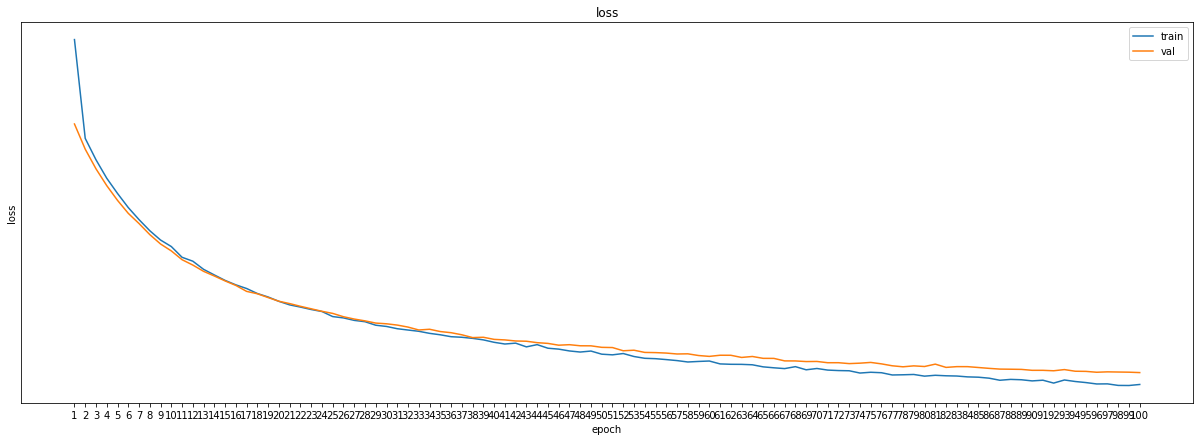

Finished!


In [21]:
network = CaptionNet(n_tokens)
opt = torch.optim.Adam(network.parameters(), lr=3e-4)
train(network, opt, device)

### Inference!

Для получения эмбеддингов нам понадобится предобученная inception_v3

In [22]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().eval()

### Generate caption

Функция ниже создает описания путем семплирования согласно вероятностям, полученным на выходе сети.

Реализация, использованная здесь, проста, но неэффективна (n^2 по шагам lstm).

In [23]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    network.cpu()
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
imresize = lambda img, size: np.array(Image.fromarray(img).resize(size))

In [25]:
import urllib

def generate_captions_for_img_url(img_url):
    urllib.request.urlretrieve(img_url, 'data/img.jpg')     
    img = plt.imread('data/img.jpg')
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

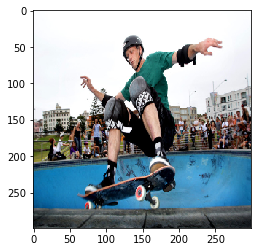

a man riding a skateboard on a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a man jumping a skateboard up the side of a ramp .
a man riding a skateboard on top of a ramp .
a skateboarder is doing a trick on a rail .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a skateboarder doing a trick on a skate board .


In [26]:
generate_captions_for_img_url('https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg')

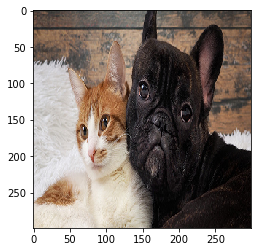

a black and white cat is laying on a bed .
a black and white cat laying on a bed .
a black and white cat sitting on a bed
a cat is sitting on a couch with a cat .
a black and white cat is sitting on a bed .
a black and white cat sitting on a bed .
a black and white cat sitting on top of a white blanket .
a black and white cat sitting on a couch .
a black and white cat laying on top of a blanket .
a cat is sitting on a bed with a remote .


In [27]:
generate_captions_for_img_url('http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg')

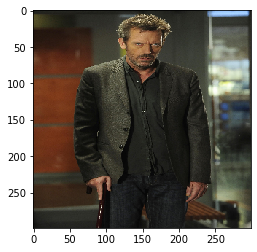

a man in a suit and tie holding a cell phone .
a man wearing a suit and tie standing in front of a building .
a man wearing a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a store .
a man in a suit and tie standing in front of a store .
a man in a suit and tie standing in front of a building .
a man wearing a suit and tie standing in front of a store .
a man wearing a suit and tie standing in front of a building .
a man wearing a suit and tie standing in a street .
a man wearing a suit and tie standing in front of a building .


In [28]:
generate_captions_for_img_url('https://vignette.wikia.nocookie.net/house/images/c/cb/Family-Practice-Stills-7x11-house-md-18727570-1786-2560.jpg/revision/latest?cb=20110208061821')

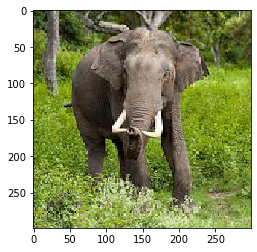

a large elephant standing in a field with a tree
an elephant standing next to a small elephant .
a large elephant standing in the middle of a field .
a baby elephant standing in the dirt in front of a large elephant .
a large elephant standing in a field with trees in the background .
an elephant standing next to a small tree .
a large elephant standing in a field with trees .
a large elephant standing in a field with a tree .
a large elephant standing in the middle of a field .
a large elephant standing in a field with a tree .


In [29]:
generate_captions_for_img_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMWFhUXGBsbGBcYGRsgIBkdHyIdHxsfGxkdHighGxolGxobITEhJSkrLi4uHh8zODMtNygtLisBCgoKDg0OGxAQGi8mICUwLy0yLS0tKy8tLS0vLS0tLS0tLS8tLS0tLS0vLS0tLS0vLS0tLy0tLS0tLy0vLS8tLf/AABEIAOEA4AMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgABB//EAEYQAAIBAgUCAwYDBgMHAQkBAAECEQMhAAQSMUEFUSJhcQYTMoGR8KGxwSNCUmLR4RQz8Qc0cnOCssKSCBU1Q1N0g8PTJP/EABoBAAMBAQEBAAAAAAAAAAAAAAECAwAEBQb/xAAxEQACAgEDAwIDBwQDAAAAAAAAAQIRIQMSMQRB8FFxgbHBBRMiMmGR0UKh4fEjM3L/2gAMAwEAAhEDEQA/APn9GjUv4AQbnbY+c784mwVKg0mC8jTfi4IxdmszTpVFQxp0w+ngnv3jHtfIIXFQPbfvHkD545Ippk08mq9jK2lo7ghhEyP7TOE3tnmGSvTAExTFjFrn/WcFez9SKvbn18vntgb2zrr/AIqqmi4FONQuF0gkAjiTHyOKaqtFG8FWROoI52BuoAkA2EdzxgzqFFIvPBlZAk/rjN5XqLI0ENpBt5DcQcaCpmQ4KyTIvO8mIII7dscb/A7khFhndM6XrqqZAQSWM389+Ywu6x1EVahcA6RamDMqB/XfDLL1G3RSpWATxt6WPkcR6lRo1aZY+GpE+D98jgrwbb46kk44HeQfJZCV9/U/ywSYG7wJ7wJwGlepXKlYAWWC7kTtPoLYcezGUp5ssHaotFYGlSB4iL+E3IAER54cP7DBSfc11M8NYx2Mb4VppUkDJg87kKykggyJP+mPUrH3QlRb0n6Y2mY9lM0BqgsFB+Eg2H0tjJV+n1wrN7ioEBgtBtybdvPbEKk3TQyKKtG1rT9n6HDjI9fclaGYX31OIpmfHTt+653H8pOES1T8MypuD+uCadSGSN5AP5Yu3TUvUJ9E6nTUplnnUHGlGGxBg3H3zhOEL9QYIBpQKCfMDBPs31GkrDLV+G10iZseR6Xxo/ZvIBatR4A94xbcc+Z8sWStmLOtdPQUqdRlGsHwTuOTBxhvaXqekaY/aEm/CDib7xjT+3vtCtMBEGpl+EfqfLHzzKMG94zks5vMTJ5kYlqzS4ML67nUrG8EccczgzJZZWbWj3NyDYCDx+FsEVKCHxFoYpZY2PMcYp6f05hBLxE2/wBO+OZTsHc0lF0NVjq2I23mO44wt6lTSKkDtaTJPJXzxfl0pgQSUcREbERz88X56lUKFQACBs3Y8j+uIzrduNJZB6OVpVKOhUCVFIK1rkknjbcCcL+k56olbQwIF+41g7yfPFmTzppNoqsTqNmE2bYAg4BqZopW3BsJEG0Gb4rtpUspgNT1HJLQAqUdZpsACNRJX13jtGFWQy9SuW92WCgwAQfoDgnpuVas6IT4HJNQhiAAJ0iMafMV0y6lF06R8MAzteY5m84itTa9rdv6Api6h01jlylQf/OQSwNlIvfkTiXUSELXtYAg2+WCc71wVaWlV3uRJi3684y3VMzcBKgMC57Hyw0ZSlzgZJIg3s+q1VdHYliCoa4vvcCTYHFPV6VagzBtLI4hSBEECQD8pxp0YSoUwALmwtudtu2Aup02ZSNR93EtqO1wVAtg6WrJySYrQJ0WqBUBO3Plt+WAP9ozRmYMBvdoQe4k4N6VSYsSB9OPuTgn2/yqPoqaRrNMCZBgAifSZ7Y9GbqNsZ8GHymcVhpMLYSfPDfLZhXABkMsDUp39Rz2whzuUMkaYiLR3/MeeL+luq2eVJNu39vniU8xZNpGvzCkqKbGVMloYgnj5xgLMdPrUtDKxZpWARPoJwx6Wyk3eQRaL/e2GmYzCmoChkagfhggxA9cQWttWA7nRmG6gmv3kVKTTDFV52J7Rvg6l18osLXDAEgSI35kQZ+WDurdNqKzPuANxH3ucI+mZH/EMV0KSRJJG3me2KR177DRk2PaPtnmqahRpqFezQY7EERjRdI9q3ropYGmQStRSh7eHS2zA84SZL2Uy1Hxvqcj+Mwo+U3+ZwzolHXVTemyjhWBC/Q2OLpllH1EvXfZakanvKLe6WpvTI/e5KQbA7wcN+m+zmVRNVTxEXJZoA84FhhbUrs7ypk7ADgd/K98NaK1Z1FCotJmPmReRc2vxgMyihh1f2Vp1kV0halI6hq2PJBPmB54JyYqe7GpdLxFjA/XbDFK8UyhYXBmfSy/jgVa6kBQ9wIkTBv+eDuYdqMd1L2TzBZ3Z9bMbxex4gximlkhofRSNNUB1E87THIxq6tZxczE9vuRgau8qXCy0Hn41Igg9jHOOfU6eMxHE+X5yi6tpuQNmP3fF2WonSZbYAx87jzxoup5pJswdSBFvhndWPcYFy+RUsQsjve0Tvjncm3TQqqzzLVVNNiygcevn2wRRcOB7sAMAATzHaO2Fq9MYswJUSbDUDq4HOJ5Mujsg8ImL+X6eeFlGXYDCalF6lJwyCVYAED4+VO98W0fjHvvdSq6iF3812374JDa6ixExaOSNv1wn/xAD1PCdZJNjyJ3B+7YzboVDD3aJqcEAG4E/DaMVNmmKgs40ztMn5sMZr3tUDUJJckkcRhgub1qUCFREg7j69sPHSrLYUXZnNrGlJAJ7/rieWyoZSZi24A+du84VplwSJmIme+GEAjSggkyt+PXFW0sDB+XI1BdlkT5TxgzqDwiqnMg2HG537YVZWsqDSUI7mO/bBAqS4K2Ug39ePwxDQg3qp+gqWRj0Cl4qhU7AwI77/nhh1zIGoaJ0KVvJ8xePwxD2ZoxUJMzHzHJ/AYaZ7RWT3fiE7wbgm5jtzjq6zU2afuGSwYjOZAM0NIamAWMiV1EQPMTEHAGd6cS3hYGTbvIvfyxuq/Qsu0PoBgQflsTFycUZTotKmzVFI0xEFfObcTjij1UapsRqjKJ06oqghRqggxtfZgOfTzw36Vlf2ghTqAkrJ8J+fn3wd/7tioqgMblhOwWTueOLYeCpcsRqYwD8vLFtFPVbb49gxg28iqv0wMv7RjE3gm58z69sA9V6arL7tF0oOEJFxuSQZJnvhv1CtBpmLAk37xb5C9sCtVLT4o9LY7IacY8IttS4Mm3s4o8VQu6jhmJ/AnHrKlNlNLw2IaLSOAe4nDbq9JlA0kk8sNvnjNZzMAxcaov8jFvzxRGY2yufb90xyTvJxqOg5uppPvWJiIuBbiZt3thd0bojFVaDFoMb+YGNNk+lub3CTIG0n79cKwouN7bkmdvKPOcVjMBGi0xFhxhrT6cL29eMLur5BiJpkFlIOkxJHYH7GEWB3wL6vWKocgqNPETftvj2pmwVB2PaPw9NsMcxlNdMNHA33HlHbCTPUm0SNxvhmBIABK1Wp04UVATMSPof3htOF/UaWdRh/lVhO7JB8xqQj8QcF0apYgTBHPla1/Kb4NXMhidALH+b9BGC0hVFCbLZB60+AJUGyAyG7wYBDfc4IykVARVQSFIFoYHsT9eMNstpZhqBB59fWcAe1eSQV5b4tKurAxqvBMbEg/OJ7Y5tfSxuiJKNIU0bVToeSCFTuT5+fGBvcEpWYk6lsTyDtvgujAcPJJBBU/jfviWfT9qzIfDWEsBtI/vhNBRk2Tjkz1d/dhVUWIG/l2w0jSNIUzY3Fo8u+BM1mNBDaVYg3U9sD0+puTLGQfhAi2BtlLIG/QLy1KorEkAiDaLfIYnmarJ8IAZoJ7+npi/L5mRPb6YF13LE27+fYYbLeQxyNEyqe7Duzgg7fFEWN/xxZkKf7QJawuZkdwZ5kYj1CuhdQHXT4tyRBETt8U9se5RyATAENptfg87xfyxuku7fcMTU+ztNBVZptpbTP4TfCzK56GABs1hvedpjaDGGHs8GN9Im0E/38sYTP8AUCAvYsYMEEgW+Yxuu09+34/QzNqK0FhqNxcTeefyxfTIVJa9iWPaDwO+wxnMr1BWTSEE994EXbeQcX9XzYIUJtz5x3x5mn0z1NRR8QvLoOOekkzE7+ePctmGZgq7n7J+WECVpwZ03qiJr8FTWRAZdJgdgCwM2vbt5495RSVIuhl1thKiJjzjg/1wtGY0tHHfb6Xvi45ssNbIVEeENEj1gxPETbC+vEQfineLD0GCENzDMymLDz+98Z+lkE/xCioYUMSfQCfxE4NFR1JEW+9jgVs2Eqh2AZYCkH+Y2iObYID6f0TNKwBAtFp4xbmupAvE27eeMp0bOFAR+Pfb9MSpO3vdQ9Zwg3Y3VGuAFvcxfF6BXBBE8gn7tjJ1a7kiJ+4jD7I1SFvjBCq1ZUt/Y4UdSyYemSpmDMjkf6Tijq2ek6huN/6/W2K+l9XUF0OraZYESOCDsRqBH4WwWsAvJiqmUcVWIv8A3kH0NiD8u+G2VQwCY1dziqsFp5ioJMMVYDgBgD+ZOJZrNjjj7uMDLGwg0Ownwz3gf64E9qc2lSjRqgGFdqbDmGWY9LHHmTzzfFYgG44I5vuIwv6gkpWE8pUHaAYN/JWnBFFSZasqiBImxBF14OHPT600qYIhlZ59DeRjvZcJVVqbSGpXXsVNh8wbehGHo6csiBeYNrcj++PO+/WlrOMvPQ58RZis7QLrKqWYCRa5H9cJsx05kAJHmZn6DH0HOdHemZUzqMCPva+K6mXdoVjwZMTHA9ZxOHVqKFM1l6WpLNbmP6YhUywFgbC04dP0Or4So33jiPLBa9AZjpYxeRPPf54Eeqjd3gN0I3yKM3iAC7g8AmJkTEH64NzNXTBJ0hjwCNrD1wwpZEPqBUhREEnf0GwNu2Keq5ECiVsQhBnYgGx8uRjaHVR+8ivgFcjroLDVYkxINuV3v2xlOs9M1CHYU2DRqOxm9gY0NxPlh77N5bQzpNrOJOxsI8hBBjyxXnengVHIUXkbkhpPbyBx19XqpRTBMz2TyzoTJDpBAa0kGCD57GYxfna0wBjQDp+jSoElQfIH0HYDzxjvfSskxhOhlvcn7fUMC0NFu++B61S8jHvve2B8w+PQKhdDqxH+ZLLtPIH64KSujCV2JgYztZrW+74hkaxVwQeRbgifzxqNZqa/wm4nufz+mES1QzFX2O0cESP1OGWYq6hI5H0xn8xVisPQn5enpfAQWbvo5/ZUwTfTv6WH4Yb5JgAZBP8ArhX0ZZo0yYjT+p/p+OHeTWCY/DCjoJo1Lwe1vPfBdOrxt5YHWmJgff6gi2CHokCN8YIB1Ys1MrRjUSQDExFyQDzMC+FdGmlMtrIgUnDrAAv4rfPtgz2grGmiRZmlSew3PzsB8+cKMvTBBBJOr7+eBYEgfq+cDZiT/wDTpgjsQon6E46iDJB4En74/XC2qD7+oWupYx5X29IjDrJKC4G+pTA8wI+eGfAvcrytYrTYnj87bnm2KsjlxVVk16FYmkXAmA1jaRMA7Y0fQ+iBaZOYCGQCKcgiezcHeY/HD180EMKFiBYCPw2j0xwavX6cXUciTnWDM9J9nDlqgY1A1Qa08NgVMDxA7NaYB58sMmQkWmAxt/U+uGlWrABIEzFtvn8ue+Kc5XVtKgCPS+4+V8eTra+53J5Iu3yB0V1+AxKkGJ2nFwo+Hj+364ktKnJaTq48+wPpghKqeGRq78T9xiap8AoG/wAPeQZB24M7c4qegVa4t67H+uHFWsAoaLee8YEzTlh4RM3nucNJRjgyQizWaEW5gx5/fOAs0odSrgkEXHke3piyghIMKR338gJxbQI1+P0uJj5fphYxqVhsq6NkQKiOoFkhb3A7kkXJG48sHZ2oNUz2NpiSL4GrZYIxMkNMCLCNtPoLnyx4CbixiRvM+mOnqNZ6unT9Q2y9600yTuJPHAt6Y+aVGho7DH0WtkGRXGosIJMhbDt3kSNsfO87v9/f3xjt+yobVP3Q0ck1qE2xXmZ7ycRpkjHlR+MeqUBqpHfFNLv2+/zxOsL7/f2cVZd/EBPl+v8AbBAMHzDLOnnvhdlgWqyTJYEfgY/TDCulhifRslrzFMR+9PyA1fS2AE3XTqApoi/wqo+g/rOGmXrQRb8/vg4VpUv2tzg2inNz2sY/LCFB1SqccDv/AHwQon64CotI35jmeO8Yto1IntjBEXtvUANJDbUGM+YI+5wBkHECDPp/XbDn2lyqVUpMwBIJWSBIBg2+YxlTmlRmVTN4Hr/bfGoWz3/BFiSsSWmCfU40fTsppQOQGP8AF/DPA7AnANBbj/pP4d9uZw0o0tKkkk32Oxv/AK48z7S1HtUOzsnNkhnDGwBP4x5Yjks7q1AEyvf7gfPAo5MLY7z32uf9MWZYhSZ3Y3tY+ePJrFskHFiSdiB5/kPxxR74fDPfccYtoUEAnseLn1t5TisvEd2kXvAP4b4zgttmojRzpmCbkX/OJ4xe1Swkzp2/t3wHXy5sZkSLEefEHbgjyxOnRjzP5D64SUYpcmQwoZrWNIaCO8+vO/OItUhuxBvzPO02/timkgAJmTBgbbRPa+2I11tK7kQTvF7xhlTDQK6pTkaj4iIIJvtcT2vaOMT93TGofHpgkztMGx76SdzzilYC7mJEMZmTxYbg8Y7/AAzAowD6QvikWYxuwDTYTweMWikrTFZbVpXIUjTwYKzEm2/eMeZFGfxDw/LeO0cyR+OC3y9JW0soJ5JJkN5RdTBwL7/QY0kbDxAyeJvePxODJVleeeWCjOdWyubLlambBW0+7QwAe8sBqHbGczlAhmE3BP4Hyx9BzOQR/FpEsYYmYiOFn5c4yfX8oaddgYhgGXniD+IOPU6Pq5astsmVg8mfV8RbfviOcs08Hfy/rigvj0kOydR/w+/0GBkF57EEn5ziRxGn54YVj2qLD0wy9lgwrFlUsFpsWP8ACtpM+sD54VUamqmrcxB++cfa/ZD2VXJ5Cp7+1XMKTUB3QFYVP+kST5k+WEYyMTVqjVMHvvHpyMG5PNjkaeZYgT6+DSfUHCHptbWVYdhcCeOAAZ2PBw/ygfh3/wDRXH5JpP8A6cAca0c8hsCt9odGE+itP4YmaoBggXg/K8/ltiFJmNy+ruGg+t1VGHzB9MQ6blf8TmBSFttXEKDJPzEiRvIwO4ewl9u+rUlp01nVUD6wo8wwv+P44xnTDqqgtcsfr8vv9cbD/b308U81lKiiFaiacDYaGkR5w5GMl00eKmbDVYkDnfgSL3kAYdoRM2XT10sPCLjj6i2rfy85xdmiCqjabC/zjFWQ+IRBvH3H/l9cRzNOnYEGNtjI3uT2gHHldfG3F+/0E1ETOa0sFJvxAIEcb9trTghmurSfLmT67D64gtEGdYaNIlm77CRJIvftijOVgsAPxHr5jfnnHlpJzwIF5VwGmRcmWv8AT8dsQzOZOrwkcBTYbT8Q43mcU5OoIBJv333m42AjffEhQDCItAhibeszf5YzwAvDE6g0gG/iuCdrD1m4xOmVMSNiOe3Hfe++PBTCyJEATBvaIne1r9sVNUgtwAVnbtbyuCLDE91vzzv2NQetSZ5YE34B4kxtvfFVElTvJHmLzyI3Hn5YqasQvkZPb09dvzxRrESItPhBm3HiN/8AXDKmGyaMW92NymoglVseJIsI+uJNXcqZdSBEhJAmf3ZuQDzgDJnSR8T8XBgQZB8pjF9CpZvhgETsfi5HP35Y6X6Ewtm8VyCSZmTH+gOKM7kyIKMWBgaf4Z87dptjnQliSAANt58t4+zit8+0eE6VBAJESPUXt/XE4rsMe5ZD7vVOzXmfW33zhL7VqClJhwdJ9DtPoRGGb1jZbcwbduSB2vI+e2Bc9li6e5k/DKkifFYgg8CbYroP7rUUu3lsZMx1ekDPb7+/phXWpwYn+2GxYc8/frgSsBOPoijF6k7YjqwTC3BF8ePlRuNsazH1D/Yj7Kmu5zdVf2NJ/wBkDs9QbmOVQwf+KO2NL/te9otA/wANTbxsJb+RTb6mCB88C+wPtzlMtkKFEuFKJDKAZDSdX1Yk4W9UzXQ61R6rHNvUckswYn6AiLRibnF4GUWsmU6CwuDZR3Nr97gRbm3kcabKUhuCp/6KH4ELJGEb5HMI7VcmymgaQqUwSp94QRNOoGt7wHV2NrY2ND3dWkrqqpU0guoLaTFmgBhEGTI3GDY9NEAwCz4ZBtCgEHz0wL+gwr9h+rz1ajSBs61QbzIU6kgcDSu3kMaDM+zeYq0teXFOsrCxRwLf9UQbevnbAnsJ7C5qjnaFetSamKTVCxY0zqlGUXVjy23bA4+IspFv/tEUP/8ANlKnasVn/iQn/wAcfHum5oipTuYDA+kiPv0x9h/9orOKMnlqUjU2Y1/JEcH/ALxj4jSfxoRvP3bnFWTR9ZyarMWbmD6yIgSQPuMW01RDAJJHcgnyvwPXvgKi8KrWKsCZBMgW3EGwMiR5SBvgw12U6hEBpjvsY8/ljyftFfgTDqdj2o8gQJkEkAyYH4zb7jAeZpL72PGZEmxhPXaAQNsG5UyKkMQZk3N4JkrN/piv3cFm5ZY0kkidoDGDuT9NseWsP05+f+yNkKirp8jtBsOPlziaUyqavDBOkCQTbyi1r2wNQkBSBqBJEEi59RzP5YIoVS0wDpmxaDpk/KCZNzguDXJrI1EeV8BN/wB2AQN7Em0xgqmbe7kqwEldUqIIiOCJbFVan7w6UYyFJBuYvt/LcfFBjznHj5hVBaYYXhh4pi47E2xJxbgseeMNkczVY6YIgiRBERxbgyNu588DUJbcNG0mwHMEd9xiqvAOnUDr+GxGqTO02vP0twcXZWhp0l2vPiUqT63sVNwL4fZtVGTKWpy0axJN1EggTsR6A79jgr3YOqAAGEaRv5Hzn8MBU8ssgrdyCJAknVa4H71if64IdkAA0GTfmTFoZePlB3x0y/QRF6VWYgk+KADMnaPrPffAeY0g1NJANjHhnsb8Nb7jBTadc1JL7Ei1huYO5jvyBj2vQbQyoEb94NsSNwR3BHB2nCxWefPP7mvADQKi7jxSIWLeoO2/y8+12RkANqKtqm4svc3uYiIwKlIinI1FtfwFgBBuQ3YSCJ8sE64JZSQrNYAeFQPOI35n1jgyj+oe5k/aDKhKraZAeWU+puPr+eEhqMDDX8+/p5eRxuvaPLO9CLNoOtWPxCY1Qf4SCT2MWxi6yiPu2Pa6XU36ee2CsXaAMzO+3rhr0zolevRWoj0zJI0kkEQd5gjjy3GE9UTzb1nG49jH05ddbHSGcKoi7Ei17bXwOr1J6enuj6mk6MJmKrIxRpVlMEdiMOOl19anvz+uHPt/0dXpjNKNLqFWqLmdlUzxFhe+3bGV9n6kOR3E/Qj9DimjqLV09yNGVl3UdWrwMQCASAxAn64d+x+bqU8wHZmhQARNtO0Edr4Hpv4yLSo7rNrfvDVxsDi7pILVIWSWYAEA25tCkiw8sO2UijYZLqFelX00az0/FBgyDfcrcdsbKj7T50eEvSfa+hlMxP8AFB+kYw2UUCo7eGSSFUkzEjURHZefPDWm9yRBJ2JHAifrjyer15Q1dsRJzaeDHf7WM3VrZyn7wm1EQP3RLPJUTzAv6TjJIsMmNl7eUyWouZ3Zb8EwwE+gbGZ91EHsceh0s92kmaLbVs33TdRpKQBO+4kkWMzABIK/PnbB9cKpUkEBrCUFvoSNo+XbfAHQqzMgEgQbSPKPoRAjawOGtZ2NPwwfFed7/OAZ/peMJ1Ud2k/3G1FcTxKfh1agGUXUTBBsNBvE7kGIxdXuq1Gi3wzcDm8H8cUrmaahRuYv/MNg0fiR574Fq1hHAGw3g9o4J5x4c03wiBfUoK9iDGqxDfMlYMAkTYztiFGitM6VcnxEBiJK7NFvQHFmVrLLKwK+Gw5BsRqF/wB2bed+cRR10q3iHcbaSJsRMQfT8sBKSWcmsjUrU51tV0uIJItJ8Jt2MMD/AHxDLZl9N42k7GAfhi17/fGLlSjVczpJIkzvbfUoBJAIBk7Ajg46pSqIbuoUSCb6pgGAIiFn4t+2HUcZ88+gLIuKZGq4B2WFswOpt54vA4wRRraNTKZCQylwdNxFzN7keE7QcRzmWUuzNDQfCwG5AHiJgeG/B9cApl7g0mgksXNhp48IuB/fD44RiJBEEgRxFwSCCTaQPqOcWGgCSWNhdVEWOxEesWvv2vhdkKRJSAdTEjS5g6pNoMdvxAthrmsqkOpjVDMpLR4gbg+hgRHbthnW6n557gpgyS4j3bT+8wYQAf4rzMA3H05x5SkBi3hEQwPcWDC8jafnzioIaQYu2kGFaWlSTsujtAufW2+D89VpNNZaTU1iDoUACeSI8V5HnbfGvckagcN4rqXYgEQST4bQfMg898DJWViAxKspB0CCIIBImANUECMXo6zADPJvsTxcA87WGAYCs2lmYzO1+xHlxzh4xvkwyzeZFPx6E02DjmNjBjYj1HpvjB5jLFTpO62n0tY9sbmq7hT4TqhdI8LCY5gHwx4p7TjNZunLtbk/nju6Bumn+hTTeGJWy/MnDvoAZYBB50GwAJ3Pi34sLxJ4xSMvB8saPL0dECxBA1KT4SIjmINosecU6uX4dvqNqcEs+EelUpEgiCBvfUYm9hf9MfNOmnTWSe9x+ePqcqSdChApIKiTMnubkD1x8zzVErVbursPoTGJdDjchYHVsxcmRcm8Cd++H3sjerq/gE/M2Gx852wlOXQsZBxofZmmqAgSZMz8hb0x3NFkzTKgUwxuwi9weTsDB2E7d8T94P3SV4IY2g7Adtgf9MVuaZlKtpWVF7MNjYHiRtvxgOhRBGq5IAZF8ZMeUgeHe8DHk9Tp/wDI2Q1MSZD2gVKtEpJNQGadhLEAn6QCCf5vPGQptMHGyzWYB0uCTdgX7cCQZIMz695xmOpUNDMo+FvEh8j/AEP4HHR0b23D4/yNpvsarpYUKu9xx3GxjmxIPy7Y0SIpQgrIj6/dsZf2cfXTX6/l/fGoypmR3EEHiRx+OOuStNFnlAFDX7wKhKwDqGoQV8juJsLdsJepdRLN+wEUtK6qT2Oq8/FBIETI49cMkrqXKFl0qsBC0Btg19y57E4V57pqNDO7l0AAMzbxHSSItt57XI28bSiliXyOUuy9TShZlZXIiblTtzuYEGewjfFuezYQqgFMix94YIdXvEA/FfffAPukWCgYrEXINwNPijbvg/qL0wA9MHSN1CTqPeSsAkErM2th3CL7ADMpV0Fri4iFUbXkyNr8X3wdlWSsAX1gzAue247iUHhvt2wloU2dBUVo1CCpIN1+EXa7RefK+G3SqRYNoqB0hRCjxiTM6eAI+D1vBsjh3ZgfOV2DuxbSGlNLlbgAAgG1+Qe+I0adMpphnXQBDEaWJ2sbj+1xOBOo0qpBUyrAARAg3sRcaZ2tPztiOTq1EJQhtIUXKAjVcsoIaNxYneRMYLjax8/PcNDRemTThWTw6YJUgADgiPFqAmZmT2jFbV2lSWCPqNmGkSfDKm3iJI9Yx5VzSeIy6wdPu94WQspDQDCk+U+QGDa2VoNJCgvA1EwSmiCDDE3tBBnc+hDpumzcAuX6WrQxqB1MAzcrPMk3Onz5OLjWcF6JRnpOgUyAYBtA8MFdPbfkSJJcFzJqOoYk0msQ3LAmO02PrjypRq0kZlqFtRlSVBNPTvcEgSDpv5YWWG15/YNIRZvIBUUsjUlEQxZZIP7xCkc6b+e2BcpllYgK3iv8QYlb2B7CbgztHfDnO0WrMhpKtedUSJKaVUMCrxaTquTOoRirJ5ZRUqIVdp1MrUW0KCRFwWItaORFsVTajkDEzVtCkfAQ0qYIPEAG+kzI59MA58/takn947et8POrgNCV6h0hZ0AoAw/mcQVOoQSQfXtLqXSFqItSldp/agAEgEC6aY94sGY3tE46tDXhDMv37f5GhgSZalNjz9/TDGvJGrXqF/h8Xi/dBkbG9yIt9bul52mrBajVGBmQ6iwiwgsSuwMeYxcvScwXdKirRUDWrAJKwVUSZBCywubwCeMHXk5SS4+o0ymkNUtwBMAG0TqmbgW22tjEdZANeoRBBYm3y29MfUa2XJqIPhqVGqoCxhDTA1FvCGClmOoCDubWMYTr3Qq61abaJSqVCOgJUlrAEwPEfPfjG6VbZv2BDkRoYJO/bDfolTxXNsQ9ojFY0xTRFp28KqCxgSSV4MWEmPWcV5Q6YI++cd12rKI2eYcwSt7jjt4h+on1wjzFGrUcPTfw0wWqM8KFY7BWETIBCrv62OLmzhVQ035/r+OCKFVQyQ5ErqCndgQVkFYFp/e2uZtB5NWKjLdQmrSdghLxNOqSWvBOkkEcTExHw9r84G6/lyaa1NLKV31XhbCCdR5g7bDBGff3iyjBwP3QFmRZtUmDBK3HkQL2oq9UPualKKaqxI0lfEkqNRmdmUQfkcSgnFpsnHGSXs5m9NMiOTH1xqstniGVgPnjE9HjSoNhG/3540iVTotf9O/yx3s6kxh1ClFU/slKggztuTaxBE7SO+FfUTTUKdCrMhkCuARYk6weFPxdxB3wbnmYgvcgpH4d73mO+BUpvVWpTdhcwNJJI2g7W7X3tjzpRqb9zneGKalKoEOpiBvFhfzLGbfiMRFeL06hBABaTbzldiJ7cYnmOnupekag1E6SLk6ZHhJNvMC5BGLP8AwTUUB3BBPfmI/PDYAG9LrmolUqAw8J0tYC1zqG97DthzkHKELqlTMArHkRqixABieIwhyFF6akFv4bE8eu0XFvI+WGtKdLFSYuJgmTvpB22+zjnmqbSNSJ9VcKwUISrEkrJ3PK+pvE7xidHKKBAnUTtciTEx2YD8z8hM1l7q+sA7lIsb2nsYjEsvV0NJtMXsYjuObgc3wsk2sACaIGoIQQy3mbDgBvDEliJnvi3qfT3hrrRL3dQfCTMgqTGkWDEi408ziOVzep5dkB/fZDOqLeIRuJMj+bvfBH+AaoZdgDfckyCRrKxsDDGI5O+Nu2+4EV0hWJYMwYQGVPgj4gX1aoCkcDcxtuSjXqlVI0lVB1AloMkbmJJJ1X8wLXOJrnVciRUZQBpt8SwF1ARN4IubG+AMzWpsFolp0mnpUkGCLreN9ItEHj0FbnQyVh1d0JPiChvDLeLQCCCAextYzzieVq/s6alwxA8JJAKyVIX3g3i9o203GFtTMh6oqIj6GS5NRfD4gQWE3m4BUkwzAwRg3KFRpPgaQQWBmW4AG5JK7X24wPuZRxj2NZRSVaetFSlDqdWkj3bHkqGuTJJsZkQcJuo5VtWhGVSRLAK3vPdgA7g/CTbTpsdjIuwz+R94IJITwCGN5FvAADGo+gtfBDUK1FqVUApRC6WqSG7FgwgynhiI9L2wdOTj3+X+Qpoq6VlVpoz5tEqSfEaYaVmVUM4N4gRyJAvh106mhRGYIGCIpnUSVbxBQIuoPnbaRF1HR6FVRVp+/Yq6MRYtpIbUkmJUBtURaT6Yf5jL1KoZZ8WhFNUAjxABgF3KkajMgzyL46cNXz9Asr6llKLA1DQ1PSJJUX1Qnh8IOjWu6sRMHa+FzJl2pU/c0KfvKbJoV1J0DWGlnBkKupWkC0mNyQwbLtmMqVqUtFaT4xBAIMo+3inTGwnYQIwZ05KaqoUKvhh4Q6meFXUKkQVtcwZmThougXRlvavpq1iEqhadYKDUrKAyqCLEiRoUlBHcGN5x8/q9PqUzDLYEgNBgkDcWmIIMmMfQy9OjQzDU2JrEoJrAtDofCS+zPtAsJEYEyHTTXrBWMUaVFHTSgMsrQy6TN2YajbgC98dUNRrkdMR5np9VE8VNliVaR8LDcHjbna2BMg1MuohQ3iNoOgyTq8RjSQ1oPHnj6V0lYr1QCWp6P2imSNTE2m3j0FvDffiMZ/2l9naLMtSkiU5BLFBudQOpo+Ina/54lq6qr8QNTJls1kxVqEzKGH0tMhV8JvKswNiDxHOKveiaYpqz/s2kEReDpudwBc/j2xoKXR4QzAaZ3Nx6cja3kO2BeodIXQxaYUMQBO8T27p+JxBa0ZY+BP3MrlCdI8r7fpt+WNN0/NGIFzbY/jtPzP15xn6CgCD24/vg7p6EzZiqxJGwBPJgwJ7xj0mdKNQ9NiAA5ChAxUEA6pMnSN/Cd7DAVLU0TJEXW4udQ9ZAbkWgXw1pZdgBZllLAk3ETtsQbfhj33EARex+Qm/O5vfHm6s/xs5pP8TA0qMTfSbGJIv2ItIP3548qvAAES0GTPysNyNvnglctVVtaBWtfURA8x8/zwJ/7rzDrqBULu07KdwRbzsNhGDDS3KyiheQatkzV8LSbXvA35/tg3LO6RpggACJ3juZ4P54oo9HqAyXJ3+D9JtBmYPpg1+lkSWJEwTJExMbDjbAem6p8AcH3Bs7mgBZWBI8VyRt8j8xj3p2VqGmG8IU95MxyPx5722xPI5qkKoUmTquApPn8J3vxGCM9nKVNSKDhtU/s9QOknsJt2jb6YWklgV1wijLUw1QslUu0sA5ggHcBvEJkzdd7xgvP1nCKB7wLdWJEFTso3k7W2O29seUcjTD1KQdopStNgAdQgHxMLDSxIsLxvi/rlbVSdVSqzJ4TUUMQQHAOuIUEDUS3pGF+7jPUqwKLsUtn0NRU1AMqlmYmNbC5IB3ld++B6fVFlaIOk7Bpgk/vaf5fK1hbAWcy1OmgdKodzqWoohgNQkAEAwNJ06pufSBRWp1WZQiBZGpSpBJNiY/mF5HAx0bYxbobCND1TpSuFKvomb6TeSS2kqCYkxsB3wf0/qNOmZ16WadSKoIkHTNv3SD+e9sKGpJRKDM0qoLIrKDUJ0ITFggEeLUxF998PKHT8voSplytSkhPu0kw0wxlzdTqBGhhf54mmuZP+AZ7lr5vsu4K6tKwt5sSQ1xPbfbAuTFM6qbKsBgFKkgBiNnEgtCgTF9p3GL6NMhCzIIi4A1QbzA0yTcWif1P6flVWlDU1eJ1lhE3AB8V9hsRzvYY5U4uTS4+Znhk8nm8s1X3fiQopUavhNgLAnUSCAZ34PmVmXqCoGK/5g06eSFiSQNiRYGTsLXwHmUpvVZirwE06JnxmIJAUmdIgT2PbAdBvCtMKV4WSTp2IMxMapg/hi8ZRXHxCqQ7rZ/SCJFoJnz2sBIaLzviDrqBlvgTSNLAGGktHKmPPt2wrzSv76rLKQf3oJiOSDuZn1BOC+m6tDMxBXnwhb3I87G/pie+pNdgF/V8lqpKKaaEPxppJYyRsZInkzvuZwN7P5V6bPrNTWzKA/wAI02Ow+GSSSLHbaYxGt1F6LqjMC1RyVXc6QIMAi3wzf+K22OzQcU2qIQzC83An95mnkxMT+GOqLkxlYy98i6EA1PdSoI8IP8Un+WJMm5teMLOq5Iu+mmy09V2AhvhkBQdQgi3hHrxgbLZZtVQl7oVYmpKgAkgEGfELbd57HB1VGFJdOmpFRalQqNhY2I7x8QvxgakaSDJYE1bK+53g7ae55MruDbzHpj2pmqQpgsoYVYULqPhk31RsSskbg/PDmuPfMFEhA5gkSH8wReZMdvObYVdR6aq1FVkqMkvAVYBIXwyyydQOowBNt8SjFb9y/cRGKzaUWVdC6HM66amUWDYCb6jzBi1hvjTexnTyadUNGgsCAHIfUoU+JDvSsZi9yLWwVmPZul7ukKQp6Tu8HWYF1IBvE7kztvfD/Iq1UNScN72nKkmCQC2pYJklSADvc9th6DmmqRbkSivTIS5LMpepBtqJ8SgfwrFu4jE61JhBIkHt6D8pjB/TuiKHeg9yoBkG4DfCTO0wbzFt8CdeycQKTNrLeIk2CAeELxMifPHLr6S3WiU45wUJXVT4JmeD/eJxZXzTsw8KwdzpBn6jf+uAqVHRZiQTctf6+QM83wwQUyIIVgQIBUX3tDTb+mJw3eoU3xYNnmqQDpU2FxE9xJmDadsAHxAd4nny+hnDL3INvdqoHw+BSBaIF7WGKKWgc2mZMCL/AAwDt5Y2ok1YZ1yBVsmJOqwaZAiD5FRvPaecU5zoqMIkwIiI7cRbb5Xw6r5cMkyIJE3vN4PyN/liL0ACwMgMZEnYCIgcTE4lu29yVnJqKK6pUBc8j4RMQdMwA2zfwx2wLmOoKaLnUT4hqiDpWQCmm0qy6hcHfccW5bNVASqhe8pAMS0gKTICm0GO+LUoCoYjUC6g/CCCDtAFxJmZJEEzOAlFT3Nc+eg+e5ndC+81UX8JnWqMdAogGYpwTKykdz24IyVE0kytOig01CwqPH7QeMMxLC1ONIB3kTfY4PqdJaiH0O8lSV0yNZgwsxDckgdoiYxTVFRabGomnwwJBLgqQWl7WJJABC7Y6E7ANMp08tUFJlFWhUFSHqguVYbXDQZQ2IAgRuZOCek9Ep0ULDTfVJQKdQvoldwFYwF9Z3xmq3Wq0hqjhnQ/DAsg8IA8MDebyYO5w4yaIsVApCkbQZBtYsRE3icT1L4r+PiZD3L01HiUNLrHAtYzAhdVuMCpXqFdVQEuoMDTEkCLjaSYIMY6kn7JWAaxYggwQYuB5SRfi2L8lU1UkeoYbRFSZBsbyD2IFz388Sb3fxx58gyyJ8m1Wq7AgMykHUOAQCCDy0AWN5PO2GdDM/sjrpxBKsTaL23uN+D2wHmX0GaCoqswbczI2MAGR/LaJ8sWf4nWFHvAEM2QAiBtHGo/rgTajlAZ1RCVLLJL/wAwuwgg7iBHGPOmKpla+qYHgAF28UN2EDYes4FKslRAQCrhrgkx6zHA2jv2xPL5xGYQA3jAIaNQFzqF9wF7yPndVal+XH6U/j7BaDW92XltOoKyBolr2jaxMXHp3xa2UB1UqwKjTJUNE6QIO+407YWnNs3vBDLLASxGmCf3dNyD4dxubAzJOy/SxFNhAkks0FyGNhabAtOona218dELToF+hBKVBYVgTpIOjUG1RPI48vXvgulVFU1DDEP8AkBmIiIMmBzfeTvbGcoZpmZqcNHxNUYjwrMNCqBpmQbmLfPDnLZc30Nq03QARquASSCAoA4vPbAcJNZNuYwylP3YpqzAsJVWBuZJi3F9+LYIoZKolVioGkkEst4MGfCLyVAvP73OKKNamoUGp8YtaBINxMSYw4Dpq2MsDIH70elptz+uHiklRhFQ6SyVCwCmWc+M3gkE3gw0ibEWnvOKs/kqmhnpq6LqmpBAapMKWW02hdyNjvhzWzAA1DUdUDTMfjvO34YsGauwmZ0xA8K2B34vgpq6sa6EvuyiB6LkyCGksxMR3BZiCYAPlG+FdcVVu3iJANxN7TO94v8A64d0alztqMDROx3uVt2uNyceCmDUOqBa3MSIBAiNU9u2J3YjeRRlw1U3VvmIiLfTzxCtRkD+VpJvtM8C58RA8zjQ5RPdoxImwgAwQD6XI/TALU1A1XmTxAiSdjzjKW0KdAlKgpABYpqsjRIkdyfpIvPlha3TSs2A8jFv77fjhzVEEAWji0XI/rgjL0qbJ7w/GQDCsPDY/rEjbBjO0G8CTp+R94+ngm4AiYvx+u884NfpdRmjSQYMD04I3O22DEKhiUYxteDIvI8gNsUtUIsZAU6t+bbAGbg/hhHtfIuBCP8AeD/yk/8ADFeV/wAyj6f0x2OxV8Mr2ZoF/wAgf8f/APPCbq/+6Zv/AJf/AJJjzHYfS/pFXBiv/m1v+n8zj6vR/wDh1D7/AHcdjsWXHwH0uH7A/UP8t/T9RhnU+Aen6Y7HY4I9/j9CEuEZrL/H9/zYqy/+6H1T/uGOx2E1OH/5X1GXKLX/AM6n/wADfrgL2V/zD/8Ak/7sdjsLo/8ATH2XyY39RsKn+av/ACv1TC2n/utT/mVP+447HYvHhk2Jeo/5Fb/7dv1wdkP9yX0p/mMdjsNP8q9/4G7CjqO1P/mH/wDZjfZLf/pXHY7DP8sTAlPYer/niOV+Fv8Agb8sdjsc/cEiPTvh+X9MSb4k9f649x2D2/Y3cPp/ov5YXVfhb/r/AEx2Ow7CVVPiHy/PHH/JH/DT/IY8x2FXD89QPgjW2b1b9MeU9z6j9MdjsS7oRH//2Q==')

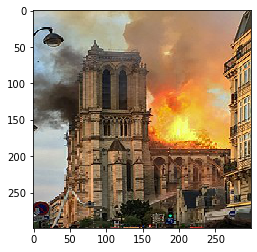

a large clock tower with a clock on it .
a large clock tower with a clock on the side of it .
a large clock tower with a clock on it .
a large clock tower with a clock on it .
a large clock tower with a clock on top of it .
a large clock tower with a clock on top of it .
a large clock tower with a clock on it
a large clock tower with a clock on top of it .
a large clock tower with a clock on the side of it
a large clock tower with a clock on the top of it .


In [30]:
generate_captions_for_img_url('https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Incendie_Notre_Dame_de_Paris.jpg/220px-Incendie_Notre_Dame_de_Paris.jpg')

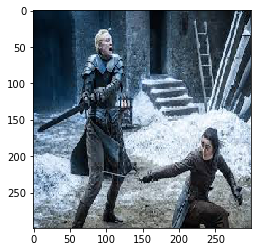

a man and woman are standing on a bench .
a man and a woman are standing on a bench .
two men in a park with a little girl .
a man and a woman standing next to a child .
a man and woman are standing on a bench .
a man and woman riding a horse on a street .
a man in a red shirt and a little girl .
a man and woman riding a skateboard on a park .
a man with a hat and a child in the snow .
a man in a red shirt and a black hat on a skateboard .


In [31]:
generate_captions_for_img_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGBgbFhgYGBkZGBgaGhgbGBgYGhgbHyggIBolGxgdITEhJSkrLi4uGSAzODMtNygtLisBCgoKDg0OGhAQGi0lHSUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAIHAQj/xABDEAACAQIEBAQDBAkDAgYDAQABAhEDIQAEEjEFQVFhBiJxgRMykUKhsfAHFCNSYoLB0eFysvEVMyRDkpOio1PC0xb/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQIDBP/EACERAQEAAgMAAgMBAQAAAAAAAAABAhESITFBUQNhcSIT/9oADAMBAAIRAxEAPwDjiHEobFZTjY46JWFixONCcR6seg4NlpMpxLSqwcVgcbzitp0aMlmSyg8x+dufviWvVtt9+A/CjcxNxgjytjWXplZ2jqPP/P8AQYqVpxZcDl7C39sRNTMwYwqqB1UGZ7Ykp0/wxNWp7SPycS0KcxF+wvidHtVorYfnmcWEPbbEtTJvT8roysN1YEETcWNxYjHtBtJBN+39+WJ0re17g7D4wuDAIH0PuNsGWy0/Zm/MH87YD8LMVVIESTEc7EdcG6zqm59NzPuBip4V9Q1jAn/P4DA3MAEGP7XwTZltLRPb7sU85QNyZt9OfTnhVRK40sVT6DFCMEeOrFX+UficD8YZetsfE2XW+GbI0/LI3AH4genPC9lVw0ZOjKjcWB/Dli8GebSs1t/rGKNSsQRsLG/X64I1R+enr3wEzgIgzNz/AEwUYruXqFpk7dvebev4Y2r0p2vOPOGTpm2+/sMHcqFfKZhdA1IUeYBaAb33AucE8O9UBpKOeNKyjlibLkbtsPY+mCPiCkiuhRNKtTVgLxMkHf0H1wtdD5Aai25YgZcXVog7AffivVPphKU6i4Zv0ecIFbNBnj4VEGrUJ2hflB/mj2BwvOOmOhZHJnK8MSnAFfPsv+oUphRHQyP/AHG6YMZ2WV6XKPF3KZvPvKrrC0E1PBqEELKlip0rpMgC6npfm2dqExMWsANgJJPc3O5kmd8PXjmoKYoZGmZXLqNf8VRhJkdQP9xwG8OcAFcmvUMUabARBPxCBOnppmJPQxzxWXfSceuy8eFVeakSAY9RIxmH3McNaoxeB5jNxjMPgObl6jG+nHq4kGCQWo1XHrDE1MY8dcPSeSAHEi4ii+Jkwoqi/B4BEk3BjbBJ2BO3Xb79weWB/Bqcstv3uXY39sX64JNwdtuW3b641njG+oVHbFvhuRevVWlTEu9lmAJgkyTsAASfTFcVCoj3v+euC/hXOaMzTYn98dAdSEAAxvJA9YwW6gk3XR+AcCoZamVpaWrkQ9VwOpnSpkaR7E4NZjhtB6ZFVg5/fIprobcFTEgg3EHljnmdq11qBWJKKASVYgbAkWIA3gTPblg03wX0ioK1PeysCIIvKkHfrjlltu67JhNEPxDw2rQrtTrMWNiryT8RTs0k9ojkQemBLIAfXqMOfjNQ5oEIUChkI1o8hQl/KTBjqZPMDCnVUE88dMu5ty5Tjlpc4IgNUEgyOwjbnfb2wfWmCwDEETNpvvvIHlvgBwxPMGBBMiBIHPb7vuwZqMEVfKbweUCJ3vb89cOeFWmdooreUGImTf0jFCsxM9fXFipUJuQLm23pv90Y1ER6TebTFj7bYRk7jlOK0H90fi2BFdIODnHJ+KD1UbRyJwGrm+McvWuPiTKi2GnLqfhC3If0wt5VbbYbMsIppsbCfXFYpyrzUCIgnoAO2AtbLMZBgkXHpgnWBm3KZj6bYymkRe5+hOCidK9LKmmoBF4ntgp4XcGpUpHarSZT94+t8DakEGep/N8T8HzJSvTjfWB+fqMKGho1qEEfDrTH/wCRP/574n4w4enTZAwpoSiliCx8qm8ADkdsWeM8Lo0qhDVHUvqYBUVwAXYC5deQmO+/SSrTR8hUFN2f4TI0tTFOASV5O0nzTOAF0jn+GKtYXxZDWj89cVqy8sSpf8LcHOazVOiB5Wbz9kF3M+gj1Ix0dM4lXO184w/8PkkK0xyLKIULyuST/MuAXhakMnkK2cP/AHK00aJ5gf8AmMPofdBiXxCv6tk6GSFnqRWr7bmyKe1v/gMXOom90tVGqV6smWqVqkWE+ZzePSfux0vhudo5OiMmclXqhR5jFDzEmSZFW0mSBOAf6OuF+Z846+WmCtLu5+dh2VTE9z0xd8S8S+DSar9tvLTncNzMRsoBPTlzw8Z1srfgKz3ijKpUdIcaSRDJqIixBZHKmNrYzCCamMxPOq4QOjGw741xsBikPUaDjdt8eKmN23xSdq7b4kXGrjGy4lY1wRjqWADE/n8cEKzTBPXn9ScCeC2dY6mf6ffg5UXV/wAW6ch3/HGuPjLL1XpZcm0SZgc5mI+uGXLfo9zrprCqgiRrcKdt4WTjbwhkXeqvw3pqb/MC5X2R1I/tzwZ8UcVr/EWlVYIqnylGlGI2nYz/AAkehY4Wt3Q8myDxj4qZjU7EqbsEO5AALLMSQbEEAgEG4M4K8O8ThG87FgeZHLt/acT8cy9LMKWiNUMAPstE26QZE4WuD+HKlat8L4jAKNTE3gbSCbziM/w2dzxr+P8AP8U58G4FlsyBTylaknw9VRwzVbtUgbsDsEmL/N3xS414Qr5c62AenzdGlR/quCPXbBh+G5fLZZwkC1yTciQSzN0tJOPOG5gVw2qvUSi4MaG0NAtqZt1AI+UQbHV0FzDpnlnu7K2VpxVVLzrAsDIkwBPTtgrxPLkSqqbHe4C8yDMC8zgdTRDV1JUSoFKgMGUyJHMWB2k+nbEubdQG1ODqJsDHK9xt09sKBmV8q+cDVAO4Ii1xpYgi+42640NcrUKholdoPXa0+vtiSjXgSvmYdCSTO0GZtG2ImbS2xLgRNyPMAZ6dNvbAYD4hP7QAbaBPe56YX64vhj8UAiqm16Y2M/ab+mF3MC+M8mmK9kR5R+eeHKnakgBiUgzABkA8+0/XnhV4LS1QOX+cPP6n+zVdzp/J9v74rHxGXoQU/ZqWO621CDYidI5+o7YhQFiQpB3Bi0DY/daI5xiWqsAMpCn93YmB09DHriLL0pJu0X32B5b262icI1KrRHM39Qfu/pjRyFOoCSCGE725T/XF6tRvZoHWZJnnihXSC0bAnZZ37W5nE1UHPEWQRqwf4qUw6KfMHJBiDGlTzH1xJwHLJ8LMURXpuaiHSEFSZCsb6kA6c+WN+MZY1svlnUjUupCWdVH1Yibg7dcQ+Fsg1LNKzvS0wRavSIubCzXmPocALmXAsfp7c5xPlMma9WnSQS9Rgo2MEmJIHIb+xxrxagKdV6e2l2AH81j9ww3/AKPaHwEzGfqCRRXTSB2NV7C3KAQPR8KHaNZjJpUztLLA/wDhchTlydtSgM0kcywE/wCl+uE/NVaufzhKjz1nhAfsqB5Z7Kok+hwezQFDh4NSDWzdQ1LiWKAWM8pYz/MRi1+j3g4Wm2acfNKJO2kf9xvVvk/9WKvfSRyrTWktPLJ8iLC2EluZ9TM3xzHxjxP49eFMrTlQANyPnf3I+ig4dvFmfTL5cmmirUqyqQACp+01ug2PUjvjmvDsia9UUwYG5PRRuf6e4w8r8DGfKGlw+s41JSdlOxCyDFj9+PMPozKJ5Esq2AHIDGYXA+bl6DEgGPaa43C4uRnaxMe1hjwrbHvTFJV2F8bqMSuuMRMTYqZLnD/mEQbj+mGepVRRDsqgz5pPQkmw7R0k4Wcst94NsHM/llKsGusHftc3G22LnnSL72McP8b5JaVSkXq3vpSggTsF1BmnuSOtsKPiDPZhxUDkqsixMvBIhGfqJE2E98e8PpqlIkU2dm7W36nblsDvgTxfNsdIuvIrM95m19sZW/57ayf66EOH+IXstdmYQAH3YRsDzI77+uLNTj9UVQ9EwgEEHZxuSwBtHKDI9yML4QYu5KhVqeSijOxtCAkmTzjlPM2wT8mWuOzuGO+Wu16t4kevUpoabFFYEoHkuwMr5oHlBi3vvEOjcFZP21egyr8zUxVLi2xdDEtYC2BnA+D/AKlQL1xFSo2lwhVqlMfZBpmCQReQWHmBgi+N+N+K2Sj8NjrDSskjWq7qZCgEQI2HvGKwy16nPHfWKnkGpvU1IrIGOoA2IGw2mdutrcowSzwKKLq3lknlG58ttryP84rcAp/tk1BSrcotBiD9Iv3xrnwQ2hbAfZMMAZIO5MjseeKnib6hTMNAVYC7yBz9Jj6bYNUspUCs7kQFMyQYkQD83zRyvGKuRUuQhM3Gnyi9j5gRaBa3fHQspmshpZK1SW0j4gZLDn8yrvJvfDk62XvTk/iLhj1HQ0hr8nm03gybesfjgWfC2bNxQc+398dv/UeGKrAVQAYkBz6SBG/p0wKrNwxDd9UG3mYH6qn554mzGqlsc84N4ezSCGoMGJMSVH4n1w103imtNzD2ldztaCORF9+mLVTjHDFM/CLbyPNG83sMEafjrJBdIyo09kUR6YOoNWkzO2gQJKwCJB68o67R74rZRliC29xMncXBuIkxe/L1wb4txbIVjIyzrMzoqFfeCCBgdWp0CJopVS4k1KilI5mQiwfUxhX9HIG5qoskqT5doETNu0/5xRzFaQBcm5IsevMYvV3kkkG3Kbgi146RviOQF+TzHrzEnbvIPUYixUolRDVeH1EAlqdRSqgSSCQNv5jgdw3g+YSrTJy9UBWQmaTQACDe3v7DBDws2o1qU/8AcQhRNweX+4fTACvV/iNztqk7YRiXirKkZ1xpnXpcC83ABgddQOHjiPCdJyfCk6ipmSObESZjosx6riHgfCkq1MtmWEUcvltdQ/6AGpj1kk/yHriDIcTYUs3n3vVrfsqRm41zPsFSP5e+AB3iOv8ArueCUvllaVLppUxq9Nz6DD3xFAnwqFKyIoC+1rn6z6nCr+jvJBWqZpoimNFOdtbC/uF/3jFvxLxVadCp5lNZraA41KjXYsLkSsAH+KeWLx+036IXi/i3x65Kn9mnkp9NIN2j+I39I6YI5bLjKUDqj4tQS/8AAOS/TfufTA3gOXU1PjPBSkNUfx30Kfpq9h1xU41xA1GN9zJ/tiZ91X6VK+ddmLaiJ5dMZiMIeQP0xmI3VaiouJBiRafbG4p46I56hGN2SwON/hYnNI6QOk++KTVIjE1JOeLQo2xImTOHotvMrRnlzH5+6MHM/RaoCqiWbSoFxJN51HawP+YOIOG5Cr5mRGYArdVJuZgGOuPPFPE6q1/h0oUKVLsQBcX0g79AY5yOsrPrFWE3k0qZWrTVkFTUUE1U0MARq3WoVBMbT6TvgXluEKHp1M4lRKLsIe621CZABYahaYHUYvZjiFCqlNKCrRemrHUJNRiRLangar9ScBc5xt6lEUqhLQLMWLGZmSW2HKBaMc9rok7OdGnlQNJytJdVPUhK03YwSrGahN5IsPW42qZnjjiAoWnEK4RFCPOzaWB0sQfswfWBCwvFHmkZ06BDWkkWJF+dvYxiPM8QeoxMnmZ53JN/rg5fQ4i2b4pUqGWZibiSSxiOTN3P3YIU+Bl6TE3Z6bCmTIBJXTz6Sb9/qEyaBh93+MdFreG6/wCq0pr6FQ0FFPTq89Wqq/E1ggzLCV7R3xWHfqMuvFThmVCCnqA0IkTMM2mAeo1DUN+Q2xUzWWOtjNid9jexud98EuPeFcyi12fMBxTakGAplfLCnXZvKVUbX1BRebCXgPhyqc0UerqGuorHQt9NOk4PMj/vC3Y9cXhnKWeFxa+HfDzs5aCIElyxlfb97teJ74I+I/CdUOXptrRokEQUiCxJECLev44ecrlAhKqPL0PLF7lyJ5Af3w7kmYuSeGVyyVHbNSUAgKNUztsCCIwd4onCH8wLidhT1D/cIxc8WeGajn49IKG+2o5jr3P3+uAnBs1kaSEZmkWqncxKqOQA1AjlJJwqoLqPwtWUinXfTPzH5ukgR15EYnHHcghlMip/1yw+9z+GL2dz/CgIGXc/+4J/+z7sDq3GckACmRS22qR7nfV74k2g8TZZbrw/Le/m/EEDfBrJeKq+YAy6ZOgykWphCywNzG0d8Bl8W0laUyeWU/vaFJ/24sj9IOZIhTTQcoSI9Bsfp1wtnoM8TZJ6VVf2Aokgsyrr0m+4BJ7bR+OAWaoy1hbn6kW59j9MdHyGb4hnAPKrKJOp6aRfkC4I+mAvEfCeaLk/q/PloUbx5VDC3pbD9Is8ELJXSeZgHlf36iMS8S4hmqdZ6a16gAYhQGIAWZEexGC6+Ec0GUih5pB+ZAQQfXtODPCOBtmq4MURSlQ5amrVGIjWo6eX7WFobSj46cOpUGYtXzriS12CMfL/AC6QSf8AUcBvHNREdMpSHkoKAxH2qhF9tyB23Jw2rmfjZivnWj4OWVloi2kkCCV9ZA25gWjCTwCHzJrVJ8hNV+cuT5B6l7xzCnBobNsDJ5UIwtSTVUFhrqNy2/eZVGxgeuOY1aVXM19bEB3uzABQFHzM35M2GGfxrxBjoogmSddXe7m6rsBCqY9ScCcpTaFpLAq14Ex8qcha9zf0jDs30JddqWcUQ1Kh8iSxLGJJMCYtOwGAyUZN9+c/fhm8QZVaJ/VaZDGneq0/NUm452UGOkz0w5+CeDquTLZhEdara0VlB8unSG25iSOgPc4Vmzl0Qcv4XzNVRUSk5VhYiACNrSdse46Tm/EdFHKNUVSLabWtYfTGYOELm5dX8NZmn81Ixf5SG23MKSQO5xB/01+YI9jhz4nn6Vb5np6pEt8NlaBa8NHfbFPK0aRJBqlTeGZPKR9Cfe2NrJ8Mpsu0uGNO2+3rgll+A1TujepBF+m298EMxxLLZYyM0HYD5adJXBPqSB9b4C5rxvm6rFaTMC3IKCx5SVAiY7HCtxhzG0Sq8EamC1UCmsjzOQB/z23wOzXFMqgKoHqN1nSn4TilT4FmKp1VnCf6yWeJ5KsxvsSMHOG+HsujCUNeDu0AG3KnI+hmcLlb4fGT0My3Gs7VX4OXDqvNaAIJ7vU32HMx2xrmvCecR6StSk1jZgdYU89bCYIF7dDjpHDs3TkUxTKjkAugdBAAiOvLF6hQi6yrQICMDA7yL9Yg4f8Az37Rz15HO/8A/E0qVWq1WuQlJ0AtpZ/iKHBLE2Alpt9g3G+E/ilNTVY09IVmsFZf9q7DD/431U6yhKrGo+hiNMgQHpg9wVYmY9Mc4zeYqqQwqOyTIMkQehGwYYxz1Lprjuw0Zjw2mgO0mwujqwsNzaZ5bHYYB1cpTVhGraTM2BMDkJm59Bi3R4/UazEPeNUBWPr+9/MOe+Js+ynVUIFvhzESfKVMwSLGIjth242dFJlL23ytOmqjSrMxjTDQCTtAAk8rffi3xLMuizJ+JMn9rJDKynzLBDXjc2I57YDcMzop04LAEEiRPxCvRZ+UfxdD2jBCmpZNZ0hV1Qq7LzhpvsB5ueC2a6El32JUc7XcVPj5pkJRSEAHnuBBIUACCw9r4bfA0JxBkepUqVgtVmYt5WR1o6DpmNUSSdjaCYwk/GaBqohrRf4gKAEmBEATPMYY/AjKc8z0zoVqbwGJ1J/25km1rj274eMkPLK12FSItHWO3LfHq1Rsbe35GAOZrspDg6wJka4gT81rG03P3YJJmwoGmT67j1Jv7YLEyrzRH9/xwtcQ8H0ap1I5V9UgiIFwSIHS8euJ3zjVH0BTv9k/7mmNN9tz9cXsnRdTpKWH2hMzfYbRt7k2wvD9A+KrkcqFo1MtrlCwdkVi0A21SDqt2GFSrxjIjVpyQ83NzA/lOtvuHXHUXy6uAtVQST8pgzFxI52/rgVm/DqsW05agQ0S7Eg2G4Cjy7fZPrg2NOdf9cyojTkaVli8bepUyb774no+LioApZeigG0LEdRaMPNPwzI0acvoHLQTpuSYBUA74L5XgFNTqAUk7woUG0CQBOw64W4eq5kPGeec+VokwAq/cAZnBtaPF6i/Oy2nemPaBzx0BaaU/sx6Yxc2rRE3AInnO19thg5fQ0Xcu9UqhIM6BKxfXAn3F8VeAcEroma2RqtQrTnZUJkt1mDEfw4cp6+mN1QDfCuZzAtVvCy/qyZYVWCzJOm7Xm8RacUqHgqktA06oFR2qK7MqhbqbBV2A0zMzMt7N9asB0k7bn8BjUZmeR6fm+Fyo4wm8S8ApM0CVlmLqzMVJa8qbkHl6feFoeHszk1q1fhtUrNZBTGpEmV1zE2Xaw+aLxjpFbOdJnoFPPEdWbgCTb2nnBG/1xUyyTcZ8OG8B4TrrzVBWmstUJkEgGygn942npq6DDB4n8XAKBSiY8kbKBafaLf4w4+J/C1OsCwb4bkgsROlmiAGXr3BBxz/ADXgbNfHWmo1qxX9rEIo03kHzWAjboN8XLNbTZd6JlRySSTJJkk8zjMd3yPgzK06ap8FHgfM6yzHmTfrjMZ7i9Vz3izGhScrQD1ABKqrHe0gjcC2w54S04dns1dgVU/vSgueS7n6e+H/AILxL9XMlmZXFvM7gXuxtANrYLf9Up+ZtbGVMhtQEGeZew25fjjeyZMpeJDyXgykgJrmo5HSFTr8olz9cH6GSy1Nf2aTOwVSoHbWv9Z9cM+VzAZfOlEjvuJ5ebVJxJRpoSV1+SSdC047ENuP64NSeDdvodQ4KXQFKHw5EyWa1rf32xVrZM02AqCV2JFQMfcH052wa0ZVUKIzHl9lrjl2/wCMV6KUAR+xMn+IM2/2lB2jocGxpHWy7lBpqLY2nSCoH8QIHXlihUofvVBAF9RPqes+2DjhFlkpKJPIhSbfxfjjnv6Q/FAAOWowG2qsL6eegG9+sG3qMTllqHMdhqcXarUrP5yNQRXRlBkAkpLD5Y0gHmVJ54BZ6iyNqVW/jVhB9Y2PeMW/CtEGhVkagWhk2MAfMvcTiCplgLpK33BmPVYH554w9bhz5JX81MhW6cj/AG9vpiH4jBirWkQZ27G3KcX6lErflzjb1HTuMbtS1D94d74NbLevQyk50mTFiCOvmNsHuEZjcRKmCzG5Ii4E7taBMiTiA8MWoJSzx8rfKe4bcHffmd8R5dGpuoqpB0+URZiNriZEi8dcOSwWymd+D8RrKhNbUCVYFQB3U2AHMb/3xcy/hvNlj8WpUiCD5J7xE7H22GHXwGhrZNAxYaCRvZFkugmf3GXbDhSZFHlTTIB+WNz9rnPrteemLQ55w7wnmajElvhbTKBGYm9lQBfqeuHDK8BI0ghiPNvUblYAwLDcyIOwvg6WAU8tpJvbnMdueIf1gKBpIjfSovBO4v1GJ2eo9yXClpxphSLWF9yTJNz82LFSqE+bntH+cRNmwYQDUTMzAsOxubdOuK+ZpVWYFKipe40kiOhOw/zGF/T/AIuVGBC+QETaQLd7/wBMbrYeW1riYt2nbEFJb6i0jmARAPWImY7+2LJIi4gDa8fhtgN7QpKBa3UfnviUHt74HiqTdPlN5gz9DEfQ4k/WDCkXBj29v74WhK3LyTqFo57HkceVKI5KBcQRYz7Y9FeQQw5fXtHuMQfFXcm4JFzPOPrb78ASVMyVDMYUKCSx+XvfCNxr9ILiRlwpAJ87yZv9lFI6c57xgj4kz9IKqV20UnaBDadbACPN6tIHUTyxzjifhyvRDPQrJUQ3VTIYD12MfkYNyVUxtmzNlv0kVQP2lGm0WZkJEjkAGm/eYw+pxSmtOlUIcfE0Qu5XUNmvFpucfNi5xtRB3H5gRjrnhLiaZjJ06VWCFAUghyTpNhKkxy+ZR7xi+qi7h8zdYaCSxAkbQJ2tzO/virlGqtU1sf2ceQDrsT13nruPXHq0aDqvkTTTGkaGnTaYNttr9friU1iLrAUETqJkjnp+6/rgnhLTgOCpGjb8NgbE/wCMU2pyvlmxsTA6X3vA5ffjd6wexAADX35euKVfOgSFKAn5SbgSRf7trTG+HIVEsuX0jUVJ57/3xmK9LYQyjtpHvjMLRucU/wBXFndmm+rrblpvN8ZopNAWiCJkM7kL9DAN7dcPS8Do2JRGgQSEUXsR8sGLC1+XvLluC5emZVFtsLtHcaieftjTkz4udV8wvyQgO4Ky0chcE25/XF0ZYBSzVBLC3mKmxnaASbxbHQsxl6bQHpraykgEe3a22K1XgdD5gNPexX0hpA35Rhcj4kfKh7FSo2806p9Sqkgx2xLl9EytUXgQtSBaZ3uQR23F98MVTw2ogpp2uWpz1iCrC9+/4YHcQ4cKep1oUyAGJaSXaF1TB3jbc4N7GiN408TmmTQpMrVIipUEHSI+VSLao58thfbmtY4v5+k+olpkkkz3M4oVcZZbtaY6MXhBz8KsOQZT6EgjfkfKPW+JaywTc78gP7jA/wAIZp0qsikedbgiVOm8Eek/XBiqZYg27A2/4xMVUKUAwI5HADKVzTJXeCRf1wx5ZoOFbNn9q4/jYT0k2w7dFrfRpyaBrrbt/bvjTPVnpU45MREgWvMx7G4/e9YFcP4o1I3E8iO3fkcEvEtZHpUSrc2tP+nr6Y0uUsZzGyn39GPFEpk0mglgSDN9a+QqAYj9kFMybAicdCTO6/LTEEkA6hIN/MJG9gRPcTj5/wAvnDTNOqvkKgaIkQy/a6QSD9Tjq3APEgq0xVpsiE/MPKrK3NZaTH9CMLatHWtlh8xsdMHew9BadrDfvGKqZYzqHkBi0EjopIPtYRgbluPVNwUKk7kg3i4Ow78sXctx8NMlSx5SARO3O1pxPI9LtGkiFYAPlIDRcQAImJuO/LEL/F1iCFpgQAVi+2oC1t/YWxY/XqQCgtqbuDPczFhY4tLTVgLgq3yxtEduWDY0p5V25C0kHULgCb73MjlG46Xsq4UxMWmbkHvv0HP2xL8MATbb8+uNK6sO8nnaBYH15m+DY00q1ZOmOd5Ha0d5/M40DKl3tI7gC56n8/djx1gBiwUC5I0i0c5OBme49Rphmn4htp0CSQNpIERM/U2wARQrLNIgGTJsCNpnbecB+JcXpBdyzAgiGhAViJqcxubA88I/HvGgqfMsr5tNMgFI5gFWKuwgzed/KAZwrHxG9wDIMXkkFR0mSD+N+eDapid+KcXpZ1vg5h1TQ2sfDkaVUMXksLEgdSJAM4W6WXray6ufhszR+0MLBiIkq1u0EYBUOKhaqvUJZCGVivzAFSoiImJB62xbpcfyqiPiO/YK0/eABjHLe2+GtdgniKgozBKQFtIB3J5DHRv0ccBSpQV2YyTUVhcMeYINoiYnvjnOZzy1axqinCqNKiZvck9Sdhhg4B4uqZaoPhkFABKnZxuZ7yd98a4dRjn3enccsRTgFpUBYJcFiTIvABMnqTJxdekrTIN/YknvgBwfi9KvSStTU6TsFuUMwQR139sGS4NMsdXsL9duuKsZxv8ABUALMA7QAfzPPEWbyyhTzJuTziOm31xUz6atK/B1gmJ1AMBME2gbDaelsWUq0wxE3AhpNrQee5hpwGoygsZt0DARysGjbHmMVqBuQZ9GPpfGYtDV6ikhRctLWY3i1iLCSduf1xHlc2odVEhipPzcg0XgkTfn0Ec8L+YYAU6lONdtc6nDWuA24kxcCbRi4umpLMERxZiG3BjygtJCwt4XpG840uKORmWvO4i+/l6dMaPmlDXIIHfad5/zhX4Rnq2oqzJYgKA0A3IIgSbKBC259QQRWmz+bU0EEHTGiBBVjBErbntMTE4nirkOU6weND/LMi1+XmEe+K/EfNTcWsrTy5dPr/nAjN0K21IhVM6mE9LlQCCDN95tznBOg4ICOCZAEkfNIi9rNzjvtha0e3zvnaAk7A7nee8j3wKzFDH0Jnf0eZB7inoJ5q7x9JI/DC3xb9GlCAabVdxYMOfcof8AP4xZs505DwKrozFI3+bTb+MFP/2wycWvUKxsYEcyInc9cMrfo7pUYrGrV/ZnXDBfMUM6ZAESQBN8A3zfzSJImApAUH1Eybkk/hiNNNhFFnkeSTqAi8n/ADH4bYFZzh9UVKpam6gsxBZGAIkmZI6YNZZzMGORhdhe1+ZxlPw3mlbUvxk1FiSrFTuZkSDHrhaGyxl6x2ImPw9cXySVRotLiOm35+mC3EfjUEX4oRyW8pdEZiAPMDqXUIJF5/A4iy+fpFBry6Tcroaqlww/jIFp5csEnZ29K9UzTU8lkJ7HVB/9RPtgnwFMzU1ulFqiN0OkEzBAY22m974JcF4RTrj4jU6qJqkIXDIxAufLTUhbR3iMNuW4IgH2yBaA7BQdvKCbdh/bFJCvDWfNNDS+C8q7ag8ypPJj/UCCNsMGSzbsD+xCnsT7b4GOi5ZkZg5BJkxqMQSWlS06dIJECAtuhGcX8epSfRl4qAKNTmQJnbTA7E7bxiDOlDNXUTczpIlrgXgxywRHG2ptJZibbkRb+HePvtji48UVqrhKUQNcA/Mqkh2hibEsNue2KmSTM5pyKStUPUfKB3bYe9z74fQ07Pnf0gKmzKSLGJPPpyv3wu579IdY7HoflUTG4+42wqUPAufa5+EpjZqgJ/8AgGxco/o8zcS9aioETdzY2ESoG9onBs+lbiHis1G1VJcbLeKtOBYq03Bkypt6TgXmvEZMwAs/aA0MR/FB81uTTht4b+jdJJrVWqfurTXQpjfUxn7o23OG3hPAMpRGmlR01NtWnW57yxJ374BbHH6vDcy6NWbK1igALOFKAiYBIZSDuPlGBK1dMm+k7zcz1tjr3i/jcUHRbgswB2MrBm1gZIMXxxYLhU4uhwdjfFd6V+h5d4/rjUJHUYsKZs1+k2I98JSTh9OCtm5bCZnt1k4v8f8AD2ayZVsxSamKl0O4PPSSNmH7pvg9+jXIM9cVh5RRGoMfN5zZARz5t/KOuOncRzD16TUqy03p1AAwKsbEbhgZDCxHPpikWuVeCvFjZSrruUKFXWYkCSp7EE79z1x3Lhefo5imtVJYFpX5pkNA9tvaMfPXizw02UcMG10maAdiCdRCN30iZgTe1sOPgDjTUWVIJSrCiCTpqC4gGI1bQJ5bRhylY6w+abUFWmdHIgapEDaOcyMS5pV/igi8LOkaeYgn8jAanxbz01DOHcXTSBpHNjNrHlvJ7GRXEPGDrZkEqSCFBYkxYBbQu4mSLi+HuJ0If9Aj5QzLyOtjP/2j6QI2xmAVPi2XIk061MkklErVAoJN4CuBfe3XnvjzFcy4jD5ei51+cNJkeYjVPylNNjaeV5wK47WNFBUKlRIuDFg0GChO6iY7meeGTNZMMSQWAK7qYaefmsdoveY5Y1GXpfCCOU0wYOqRe0zz9fwxtyZaLFOg1UVNOim5GoupkEnyqdyxjTcNeYIwX4Rk3TyuzuQBDA6QATZQuuTzGwgRvAOI8g6I5ZXV0LGAQsSSLiT152nnuMGzmaasoYrcwFAIIGmB3JsYIix64VpyL6UAxuCLXAP0HTHlanB5COR2a9r7zyv9+Ic5mIEqwnkAvmAPTe/4/fgSMxXqypdQTIupOnYhgCYJX0vjNS/T4spUgQpg/wAY5zp0mRsY29jgHxDiyk6ShYzsoKgkiCbz1PKTPriLiuWqMnkZKkEwVWFGkgzCyZ+b/GxBrUCqxqhGAJgWa7AEbk29OnLE2qka+IuOlqbKC4VhBADFrG0Fbzb8Mc74jmix0gKoO7JqlvY7d7DBXi3FizMSTJMn82v92B/D8lUzFVaVFCXbmxkwBJY9ABiVwU8HZA1cxTRR5VIdydoU7E9zA+uOk1csDJqKqgSSdZFvQbex+mM4RwI5Ol8Omy6hBd9J1Mx5zuBaAOXfA7x7n2TKOdQJOhZW0yRrEAbaZ5nfD1pNu65d4t4h8euxE6VOlRJMAet77438N8I+PVRSPKol5J+UEkx3MwP8YAVZZze5OOxfo+4RSp5YfEg1KgDte+n7AIBBACnVMbt7Yid1pbqClJlVVQKEBGlVhSsdDDbx1jEopaQAqSTEQpPpEe/PDDl8hTi6qxtdSYHLnN+s9uk40zVWmBp0q8m+ozeDzO3titI2X6ryJNOoNNxAvKg3BG5iR9x3xXpeGqDhJy6VCo8uoSArHUFAbkCYjlsMH81nYWAFVbiB5SekW3sb7b98DstxmkzGXZdh5xoE3MSB9/5KNpluCU6aimKVNVJ1FQqBZje9pEfhG2LIqRszeWwAvE8iF23+gxYy1em19akCQYhha5BJnl06YnRgSSxXl9ogG0+n0tflgJEqBgph4MQZ6bRzwWGTK0yQDUMToYjf33337YGKwRvKAAQYIbUZ6zyF+Y/tivWr1HkB1vEEamJJ6iAAJtvNtsMClFswWaEVVH2ZAIEbbwD/AE6YpcazbUkL6dBaR05fZgx9I5YhylMqpYvYAkhl8tpJHTcRbrbCv4h40ajAsYj5V/dHL33M9fTFYzacqT/FFZlUaT5HJK3uAAAWIH2RqiTuWO18J3wr2PpOGbidSmrNs1Qkjc6aYN9LAGJN/KLiDtOF7MOBAVjHKNhflv19L4zy9a470qa+uLCNYTJEiYgz2UfvHkMVis/8f1GOgfotKrW1PTL+SoEUgxrUoS09NLQedxhSHabPCdKmcuq0qVSkkm9YBHdo8zFQeUfQdBgm4i0iOknfc2FvyMeV8wrE+SOYIPXcASTHtz3wPoVkgnVYbgFpJB5Dbad+fvgqEvHuHLXotTqSA3PSTp6EGLMP8X2xzrheUalUbK1ahplDqDA2aBqUgRtabEHljqFLMofMvlc7BZ3PygAjn2wheNMjVVkzIBWoDolkULzKkzyJlQT++MOGuZXxXSqVVpQS7kAuouTaWKtEAATubA4aP+lCoGCMGqcpIXTfpBn2f1xzXK8d0OtU01WoBDCORUFvNFjaYnmN7jD7SeYKgywBHzEtI6de1zh3RLCcLIADNT1c5NQH3HXHmIcxZiGYhpuA0C9/38ZhdfQH874iNMAOdTEXVQtxtsbxveOWwwKPF1a5plQLkCNYvzm/Lp06X3oCixOuq2pjB85U7WsYmbH6dMb1FoUSfhhYIgrUYmwsxBSenMc+eN7ayaZKrRDmUqBjBUF9a3g2IELY9sExngU1DWjC0wGkkdYsB3F9vVd4nWov5XfTYXFNo3MEa4MAnaeuK9HO/DYqjmxE/Msi0zJK39dhieUh6Ny1KLgF1IcaYYqAxtyMfL6bzjZcrqQySdRtrWIMyINrDv64AZLOZioDACty88i8CfLJiOX5A3P5+pWgNSYFTMwzWmSCpYwDyPf3wXOCYjRq/BqnVUjb/wAyVJ3EyYm/I/a74594r4t8bMvVBKgHSuk7gbkTuCZNx0wd8VcTdKfkJUMqppmQTF2gmx/t9eb5vMkmBsMZ5ZNMYsU6pqOEALFiAoHMkxtOOs+E8lTyS/8AcBdj+0dUEsBEIrEg6Z3FyTe3JH/R3wsFzmKhKgStMgEydmaxGwsORJPTHQqVIeYfHdj3XTG2mNI232nn1OFKdXamaVns6MzRI1MSOmw6esd7459+kbi1Rfh0ww0lSSoBi8AagSTOk+07CcMlaq1IwAjL/CTq7yCsA2JieWOTcd4i1R3ZoJJNx62+gtg5bExe8Eyxq1kp3EkSf3V3ZvYT92OxLxJAV0i6iApVQI2jzC1rg23xxzgPFBRqqxEiIsdNjbcc8dT4bRp1dLpVJWQSD5T1GoRvy3xPfwdEP14ahroeh+IQAJMGPSO1jtiSpxhdOlKahSPmZ7ahzAI2/NucdZyo8xMXggduXfFZQGnzbD5mKweVoNvoMHKlqN6tVTBDLq3kEmT7czHQc/XFXO51hT1qqsWIADaVmRYsbsBNojf6Yhq0QEYq17XJmOvIcunbEKqmmSfPvJLPJnlz35yMTs9L+W4gVBlEXppZiARym0cun9cWjmS8hmA76TpGw064I37+2F3M5d99LNvA1lWsR2+Ujudj73ai1ZB0EB9THzKw814j92+17Hlh7GhYdNbNe5H125+vKcbUxSJ8tWC0ghmALMANULI2kmIOBOSgsIcMLytwAexmw5xGDdLLjY0xp/e336QAT7/fg2NBvFMyKRClvJANydpIANyIkdN1wpZ7iBaWXnOg7EKDDVI5X8q95P2Ixc4wyvVqLHkVjt0U6RA6sbCebDA3iNMoCGhWIBcfZpqBCoD0UW73O5ON8eoyvpczaKbm3JQOg39u/pi5lnRRp5ncRMDlfqfuHrYRVzBZ9QsPs9hy9+eJKdUC9/64xyvbfGahgFRdoBHYDGwenuq6SNipKGTvdSDhaqZk7AwPzucepnGGxwjOWT8Q1UN21qd1qS3rffkN59MGsv4qpNAenojYwrgGR0C99sczOfY4sU8yQQJudl+0fUcvTAXTrIz4qJAJYG3lWRcQJ8xjr1GNc0jMNF3AEE6FY7QwiwZb7STbCF4fr1hWVKbRqNwSYgXba5MAx3w/5hCALs2957yNu9uvfBsrCrn/AAwlerIqimoXSUgByADpt9k6eVx5QMOFPMVpUCGAESRJgWADX0gdv64onLyoJgt0tJG0kmeX9cS1KADG5MQYsSOfP8/QYcqalqOJPlkze678xcg7zuMZjRzJn8/jjMPZL2byeXqIyofOs6gEPXzDUxvz64XKzqoAlAACYIYsByBMRcjlMTjzGY1yTi9yfEgkwSGN1AkKBuSQNzA2tiucyVbSrGZnSZIvzJmTttt6TjzGYy3V6T5moWMzoJt5VEdLAzGNqM01UGo7RIliZP2rkCY7dIGwxmMxNOFHxVxYNUKaidPl2gD96TuWJ59voFpUtboihV1ECbyOZJ9r4zGYZuocN0oipTnQo09Yix6EmZv1xaTMbkDlOwuCLHrteMZjMSFI1lYSV+YdZmd4kfj92AGb8MUajEABTPKRJMWMdcZjMOAMbw9SBkTY3gnl6jFuhkgNi0nYofhdtkgcunLGYzFENLWqaQmrygAASxMRpuzEz6xiekocw9QqbaSQWEiLEA9OkffjMZibAu0EVxPxNZG3lYW6WIkTyJxpXcST8jRGkTpMc45Gekd8ZjMI3n6/RJgJfaCWE25aT+OJEyjSFAARjYAkETYATNgDvI9MZjMASvw9FlSGUrF5BJ79/fqcQHMUqcBQCYJvImL3gDn+OMxmAA2QXQSWv8M/Wr/ZZgTzJPIHCl4o4kSxpg3mah77hR2x7jMb59Rlh3QFaxx78btjMZjFuYeA+Hf1mmX+IUOrT8mobCL6gbz0OAeZpFHZDurFTG0gwYxmMwQkXxY/P9r4I5SL6Hg9AgB92M/jjMZgognw+sVqUm2OoT2kwcPVOuTKEeZbAjl2N4I7d8eYzCoqekpUEHzAXHW53k7+mKWczYsW1EkmLnkQCN/z3xmMw0tVrqfszjMZjMI3/9k=')

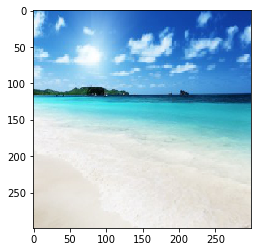

a person is flying a kite on a beach .
a person riding a surfboard on a beach .
a person standing on a beach with a kite .
a person is flying a kite on a beach .
a person on a beach with a surfboard .
a person is flying a kite in the ocean .
a person is flying a kite in the ocean .
a person is flying a kite on a beach .
a person riding a surfboard on a beach .
a person is flying a kite on a beach .


In [32]:
generate_captions_for_img_url('https://poster.nicefon.ru/2016_08/08/350x220/132949f078ccfff7fef4bd.jpg')